In [23]:
#pip install pandas scikit-learn tensorflow nltk matplotlib prettytable

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
from keras import layers
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [15]:
# Load the dataset using the raw GitHub URL
dataset_url = 'https://raw.githubusercontent.com/Ritwik2412kolan/Final_project/refs/heads/main/Breast_Cancer.csv'
df = pd.read_csv(dataset_url)

In [16]:
# Check for missing values in the dataset
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64


In [17]:
# Focus on relevant columns
df = df[['Age', 'Marital Status', 'differentiate', 'Grade', 'A Stage', 
         'Tumor Size', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive',
         'Survival Months', 'Status']]

# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()

# Encoding 'Status' as 1 for 'Alive' and 0 for 'Dead'
df['Status'] = df['Status'].map({'Alive': 1, 'Dead': 0})

# Encoding categorical features
categorical_columns = ['Marital Status', 'differentiate', 'Grade', 
                       'A Stage', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive']

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Define features and target
X = df.drop(columns=['Survival Months', 'Status'])  # Features excluding target
y = df['Status']  # 'Status' column as the target for classification

# Standardize the features (important for SVM and LSTM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Function to calculate sensitivity, specificity, and other metrics
def calculate_metrics(conf_matrix, y_true=None, y_prob=None):
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    
    # True Positive Rate (Sensitivity) and False Positive Rate
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0  # Same as Sensitivity
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0  # Same as Specificity
    fpr = FP / (TN + FP) if (TN + FP) > 0 else 0

    # Sensitivity, Specificity, and other metrics
    sensitivity = tpr  # Sensitivity = TPR
    specificity = tnr  # Specificity = TNR
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = sensitivity
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    balanced_accuracy = (sensitivity + specificity) / 2
    tss = sensitivity + specificity - 1

    # Heidke Skill Score (HSS)
    numerator_hss = 2 * (TP * TN - FP * FN)
    denominator_hss = (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
    hss = numerator_hss / denominator_hss if denominator_hss > 0 else 0

    # Brier Score (BS) and Brier Skill Score (BSS)
    if y_true is not None and y_prob is not None:
        bs = np.mean((y_true - y_prob) ** 2)
        y_mean = np.mean(y_true)
        bss_denom = np.mean((y_true - y_mean) ** 2)
        bss = 1 - (bs / bss_denom) if bss_denom > 0 else 0
    else:
        bs = None
        bss = None

    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TPR (Sensitivity)': sensitivity,
        'FPR': fpr,
        'TNR (Specificity)': specificity,
        'FNR': fnr,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Error Rate': error_rate,
        'Balanced Accuracy': balanced_accuracy,
        'TSS': tss,
        'HSS': hss,
        'Brier Score': bs,
        'Brier Skill Score': bss
    }

In [19]:
# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics
rf_metrics_list, svm_metrics_list, lstm_metrics_list = [], [], []
rf_roc_auc, svm_roc_auc, lstm_roc_auc = [], [], []
rf_brier_score, svm_brier_score, lstm_brier_score = [], [], []

# Cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"\nFold {fold}:")
    
    # Ensure target_classes is not empty, get unique classes from the current fold
    target_classes = y_train.dropna().unique()

    # Fallback in case target_classes is empty
    if target_classes.size == 0:
        target_classes = [0]  # Replace 0 with a default value appropriate for your use case

    # Fill NaN values in y_train and y_test with random values from the target classes
    y_train = y_train.apply(lambda x: np.random.choice(target_classes) if pd.isnull(x) else x)
    y_test = y_test.apply(lambda x: np.random.choice(target_classes) if pd.isnull(x) else x)

    # Check to ensure there are no NaN values left
    print("Missing values in y_train:", y_train.isnull().sum())
    print("Missing values in y_test:", y_test.isnull().sum())
    
    # Random Forest
    rf_model = RandomForestClassifier(random_state=1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_conf_matrix = confusion_matrix(y_test, rf_pred)
    rf_metrics = calculate_metrics(rf_conf_matrix)
    rf_metrics_list.append(rf_metrics)
    rf_roc_auc.append(roc_auc_score(y_test, rf_pred))
    rf_brier_score.append(brier_score_loss(y_test, rf_pred))
    print(f"Random Forest Confusion Matrix:\n{rf_conf_matrix}")
    
    
    # SVM
    svm_model = SVC(probability=True)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_conf_matrix = confusion_matrix(y_test, svm_pred)
    svm_metrics = calculate_metrics(svm_conf_matrix)
    svm_metrics_list.append(svm_metrics)
    svm_roc_auc.append(roc_auc_score(y_test, svm_pred))
    svm_brier_score.append(brier_score_loss(y_test, svm_pred))
    print(f"SVM Confusion Matrix:\n{svm_conf_matrix}")
    
    warnings.filterwarnings('ignore', category=UserWarning)
    # LSTM
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32").flatten()
    lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)
    lstm_metrics = calculate_metrics(lstm_conf_matrix)
    lstm_metrics_list.append(lstm_metrics)
    lstm_roc_auc.append(roc_auc_score(y_test, lstm_pred))
    lstm_brier_score.append(brier_score_loss(y_test, lstm_pred))
    print(f"LSTM Confusion Matrix:\n{lstm_conf_matrix}")
    

    # Combine metrics into a DataFrame for tabular display
    metrics_table = pd.DataFrame({
        'Metric': list(rf_metrics.keys()),
        'Random Forest': list(rf_metrics.values()),
        'SVM': list(svm_metrics.values()),
        'LSTM': list(lstm_metrics.values())
    })
    
    print(metrics_table)



Fold 1:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 2  5]
 [ 2 71]]
SVM Confusion Matrix:
[[ 0  7]
 [ 0 73]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
LSTM Confusion Matrix:
[[ 0  7]
 [ 0 73]]
               Metric  Random Forest        SVM       LSTM
0                  TP      71.000000  73.000000  73.000000
1                  TN       2.000000   0.000000   0.000000
2                  FP       5.000000   7.000000   7.000000
3                  FN       2.000000   0.000000   0.000000
4   TPR (Sensitivity)       0.972603   1.000000   1.000000
5                 FPR       0.714286   1.000000   1.000000
6   TNR (Specificity)       0.285714   0.000000   0.000000
7                 FNR       0.027397   0.000000   0.000000
8            Accuracy       0.912500   0.912500   0.912500
9           Precision       0.934211   0.912500   0.912500
10             Recall       0.972603   1.000000   1.000000
11           F1 Score       0.953020   0.954248   0.9

Comparison of average metrics:
                  Random Forest       SVM      LSTM
TP                         64.8      66.7      67.2
TN                          1.7       0.5       0.2
FP                         10.8      12.0      12.3
FN                          2.6       0.7       0.2
TPR (Sensitivity)       0.96137  0.989347   0.99708
FPR                    0.858044  0.964087  0.985784
TNR (Specificity)      0.141956  0.035913  0.014216
FNR                     0.03863  0.010653   0.00292
Accuracy               0.832326  0.841092  0.843576
Precision              0.857352  0.847267  0.845296
Recall                  0.96137  0.989347   0.99708
F1 Score               0.905831  0.912455  0.914464
Error Rate             0.167674  0.158908  0.156424
Balanced Accuracy      0.551663   0.51263  0.505648
TSS                    0.103326   0.02526  0.011296
HSS                    0.131514  0.038202  0.017064
Brier Score                 NaN       NaN       NaN
Brier Skill Score           NaN  

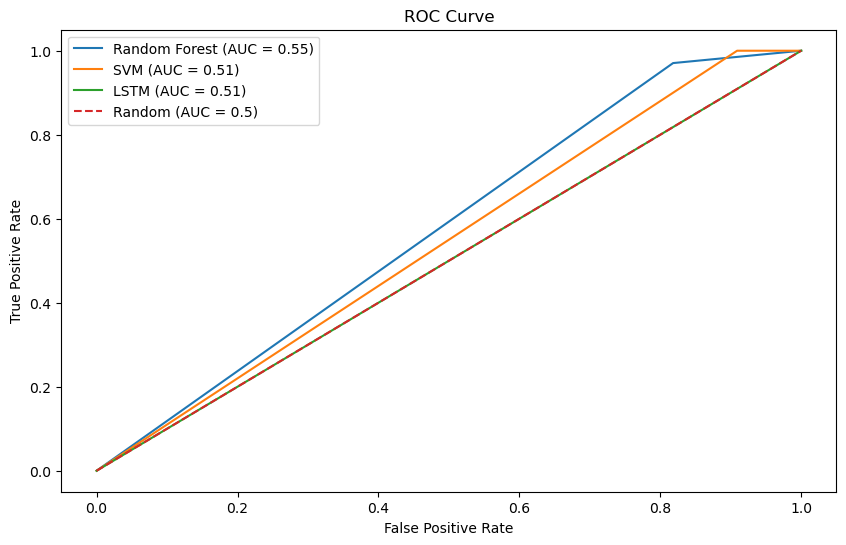

Average Brier Score - Random Forest: 0.1677
Average Brier Score - SVM: 0.1589
Average Brier Score - LSTM: 0.1564


In [22]:
# Convert the list of dictionaries into a DataFrame for each model
rf_metrics_df = pd.DataFrame(rf_metrics_list)
svm_metrics_df = pd.DataFrame(svm_metrics_list)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list)

# Calculate average metrics for each model
rf_avg_metrics = rf_metrics_df.mean()
svm_avg_metrics = svm_metrics_df.mean()
lstm_avg_metrics = lstm_metrics_df.mean()

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Random Forest': rf_avg_metrics,
    'SVM': svm_avg_metrics,
    'LSTM': lstm_avg_metrics
})

# Display the comparison table
print("Comparison of average metrics:")
print(comparison_df)

# ROC and AUC
plt.figure(figsize=(10, 6))

# Compute ROC curves for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_pred)

# Initialize the table
metrics_table = PrettyTable()

# Add column headers
metrics_table.field_names = ["Model", "TPR (Sensitivity)", "FPR"]

# Add rows for each model
metrics_table.add_row(["Random Forest", tpr_rf, fpr_rf])
metrics_table.add_row(["SVM", tpr_svm, fpr_svm])
metrics_table.add_row(["LSTM", tpr_lstm, fpr_lstm])

# Print the table
print("\nModel Metrics (TPR, FPR):")
print(metrics_table)

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %.2f)' % np.mean(rf_roc_auc))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %.2f)' % np.mean(svm_roc_auc))
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (AUC = %.2f)' % np.mean(lstm_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Display Brier Scores
print(f"Average Brier Score - Random Forest: {np.mean(rf_brier_score):.4f}")
print(f"Average Brier Score - SVM: {np.mean(svm_brier_score):.4f}")
print(f"Average Brier Score - LSTM: {np.mean(lstm_brier_score):.4f}")